# Extract a timeseries from eReefs model results

Some of our eReefs datasets include more than a 10-year timespan of simulation results, and are made up of one netCDF file for each day of the simulation.

These examples show you how to extract a timeseries of a dataset variable at known locations within the model grid.

---

## Access the OPeNDAP endpoint URL for your dataset

We begin by discovering the OPeNDAP endpoint URL for the published eReefs dataset that we want to plot variables from.  Make sure you are using one of the dataset aggregations, rather than the individual files if you want more than one day's worth of time information!

If you don't know this already, then you can follow [these instructions](./data-discovery.ipynb) to use the CSIRO eReefs data explorer to discover the URL you need: all of the datasets shown in that applucation are aggregations.

The URL we are using in these examples is <https://dapds00.nci.org.au/thredds/dodsC/fx3/gbr4_bgc_GBR4_H2p0_B3p1_Cfur_Dnrt.ncml>, which is the OPeNDAP endpoint for the [GBR4 Biogeochemistry and Sediments v3.1 near-real-time model results](https://marlin.csiro.au/geonetwork/srv/eng/catalog.search#/metadata/7bc0d1fc-d0e4-4c1a-956f-8f7cd1a6892d).

We will use [emsarray](https://emsarray.readthedocs.io/en/stable/) to help us query this dataset:

# Prepare to create some plots later in this notebook

In [1]:
# This makes the figures nice and big for this notebook
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = (8, 5)
pyplot.rcParams['savefig.dpi'] = 100


In [2]:
import emsarray

# Access the dataset
dataset = emsarray.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/gbr4_bgc_GBR4_H2p0_B3p1_Cfur_Dnrt.ncml")


# Filter the dataset to just the variables we are interested in:
# Chl_a_sum => Total Chlorophyll
# NH4 => Ammonia
dataset = dataset.ems.select_variables(['Chl_a_sum', 'NH4'])


# We can speed up future operations by limiting the timesteps to just the range we are interested in
# This step is optional, and is here only to make the demonstration speedy.
# Choosing the most recent 10 timesteps:
dataset = dataset.isel(time=slice(-10, None))


## Identify the spatial points you are interested in

We're going to use a location in Hervey Bay

In [3]:
import shapely

# Filter the dataset down to only contain information for our point
hervey_bay = shapely.Point(152.888677, -25.020682)
hervey_bay_dataset = dataset.ems.select_point(hervey_bay)

# The filtered dataset should now only contain time and depth dimensions:
print('Extracted point data for Hervey Bay:', hervey_bay_dataset)


Extracted point data for Hervey Bay: <xarray.Dataset>
Dimensions:    (k: 47, time: 10)
Coordinates:
    zc         (k) float64 ...
    longitude  float64 152.9
    latitude   float64 -25.02
  * time       (time) datetime64[ns] 2023-10-10T02:00:00 ... 2023-10-19T02:00:00
Dimensions without coordinates: k
Data variables:
    NH4        (time, k) float32 ...
    Chl_a_sum  (time, k) float32 ...
Attributes: (12/13)
    title:                    GBR4_H2p0_B3p1_Cfur_Dnrt
    description:              eReefs GBR 4k grid with rivers. Uses JCU bathy ...
    paramhead:                eReefs 4 km grid. Mile Furnas Catchment constan...
    paramfile:                ./tran/gbr4_bgc_nrt.tran
    ems_version:              v1.4.0 rev(7358)
    date_created:             Sun Nov  5 11:21:17 2023
    ...                       ...
    Run_ID:                   2.0
    Run_code:                 GBR4_H2p0_B3p1_Cfur_Dnrt|G0.00|H0.00|S0.0|B2.0
    Parameter_File_Revision:  $Revision: 1925 $
    bald__isPrefix

## Extract a timeseries at a single known elevation

If you only want information at one elevation index, then you can filter the dataset down even further before turning it into a JSON array that can be easily plotted:

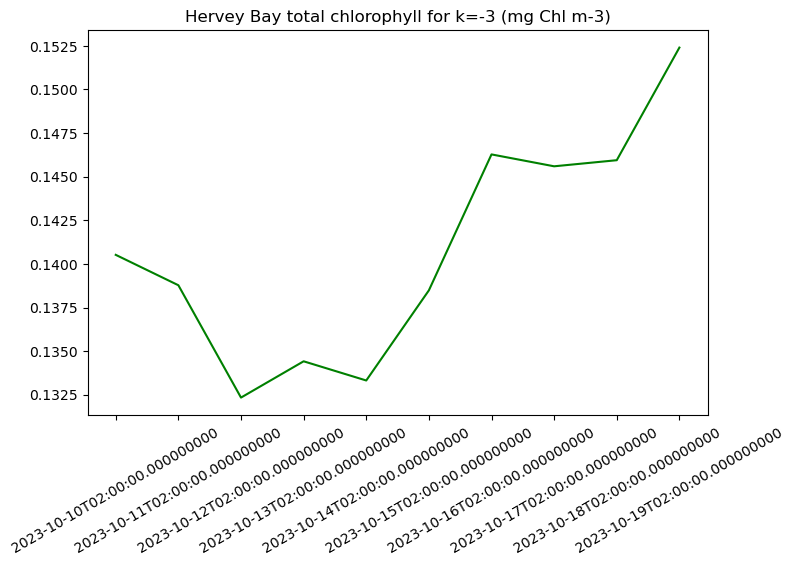

In [4]:
import numpy

hervey_bay_single = hervey_bay_dataset.isel(k=-3)
hervey_bay_timesteps = numpy.datetime_as_string(hervey_bay_single['time'].values)
hervey_bay_chl = hervey_bay_single['Chl_a_sum'].values

hervey_bay_figure1 = pyplot.figure()
pyplot.plot(hervey_bay_timesteps, hervey_bay_chl, color='green')
pyplot.title('Hervey Bay total chlorophyll for k=-3 (mg Chl m-3)')
pyplot.xticks(rotation=30)
hervey_bay_figure1.show()


## Statistical analysis of the extracted data

It is also possible to process the data before extracting the timeseries.  In this case, we go back to working with all the possible depths at our point.

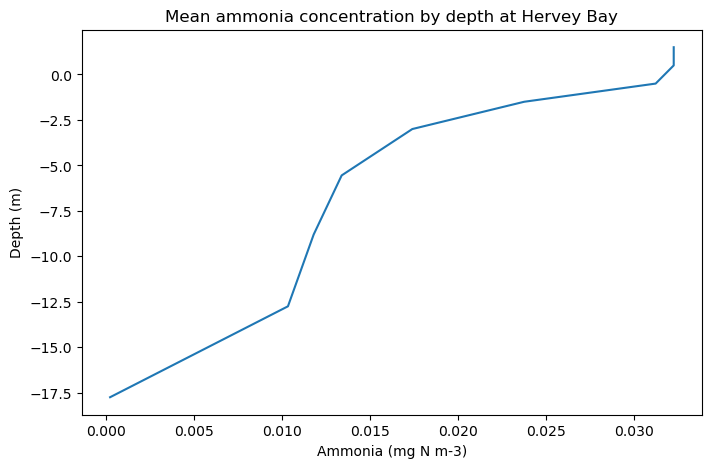

In [5]:
# Working with the Secchi depth for this one, but all possible depths
hervey_bay_nh4 = hervey_bay_dataset['NH4']

# Hervey Bay is shallow, so most of the deep cells will be below the ocean floor.
# These cells will be filled with 'nan'.
# This will slice off all the data that is nan leaving only cells with values
deepest_index = numpy.where(numpy.isnan(hervey_bay_nh4.isel(time=0).values))[0][-1] + 1
hervey_bay_nh4 = hervey_bay_nh4.isel(k=slice(deepest_index, None))

# Find the average ammonia concentration across time for each depth
mean_nh4 = hervey_bay_nh4.mean('time')

# Plot the mean ammonia concentration by depth
hervey_bay_figure2 = pyplot.figure()
pyplot.title('Mean ammonia concentration by depth at Hervey Bay')
pyplot.ylabel('Depth (m)')
pyplot.xlabel('Ammonia (mg N m-3)')
pyplot.plot(mean_nh4.values, mean_nh4.coords['zc'].values)
hervey_bay_figure2.show()